<a href="https://colab.research.google.com/github/nandomachado98/NLP-streaming-reviews/blob/main/NLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 16.5 MB/s 
     |████████████████████████████████| 212 kB 58.6 MB/s 


In [39]:
#importação dos pacotes necessários

import nlp
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns

## Utilizaremos uma base de Reviews de Streamings Onlines da Rotten Tomatoes.

### O primeiro objetivo é construir um modelo de classificação de reviews, que consiga os classificar entre negativos, positivos e neutros.

In [8]:
#importação da base

from google.colab import files
 
 
uploaded = files.upload()

Saving audience_reviews.csv to audience_reviews.csv


### A base contém três colunas:
1.   Show (nome do seriado)
2.   Rating (nota de 0 a 5)
3.   Review, o comentário do usuário

Trataremos de criar uma nova coluna que classifica o Rating em:
*   Positivo
*   Neutro
*   Negativo

Classificando o Rating em (0 - 2.5 = 'negativo', 2.5 - 3.5 = 'neutro', > 3.5 = 'positivo'.



In [9]:
# a nossa base sera o df de treino

train_df = pd.read_csv("./audience_reviews.csv")
train_df.head()

,Show,Rating,Review
0,Test,0.0,Test review
1,Loot,2.5,"I love the stars, but the show is riddled with..."
2,Loot,4.5,Great show to watch. It's something that's eas...
3,Loot,0.5,Another Apple tanker crashes into the reef wit...
4,Loot,4.5,"This is such a fun, endearing show. It has a ..."


In [32]:
# Criação de coluna adicional, que chamaremos de Etiqueta

def nps(row):
  if row <= 2.5:
    return 'negativo'
  if row <= 3.5:
    return 'neutro'
  if row <=5:
    return 'postivo'

train_df['etiquieta'] = train_df['Rating'].apply(lambda x: nps(x))
train_df.head()

,Show,Rating,Review,label,etiquieta
0,Test,0.0,Test review,negativo,negativo
1,Loot,2.5,"I love the stars, but the show is riddled with...",negativo,negativo
2,Loot,4.5,Great show to watch. It's something that's eas...,postivo,postivo
3,Loot,0.5,Another Apple tanker crashes into the reef wit...,negativo,negativo
4,Loot,4.5,"This is such a fun, endearing show. It has a ...",postivo,postivo


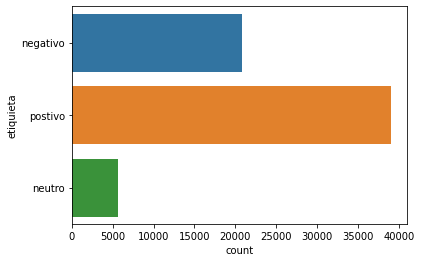

In [33]:
# Vamos checar quantas classificações temos em cada etiqueta

import seaborn as sns

sns.countplot(y='etiquieta', data=train_df)

**Fazendo a codificação dos valores de etiqueta para cada valor na base de treino**

In [34]:
le = LabelEncoder()
Y = le.fit_transform(train_df['etiquieta'])

In [17]:
Y

array([0, 0, 2, ..., 0, 2, 0])

In [18]:
le.classes_

array(['negativo', 'neutro', 'postivo'], dtype=object)

**Separando as bases de treino e teste, com uma amostra de 20% para os testes**

In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_df['Review'], Y, test_size=0.2, random_state=5)

**Representação TF-IDF**

In [20]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', LinearSVC())
])

In [35]:
# Treinando o modelo

pipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', LinearSVC())])

In [36]:
# Testando o modelo

pred = pipeline.predict(x_test)

In [37]:
# Acurácia do modelo

accuracy_score(y_test, pred)

0.8434185425410149

In [40]:
# Aqui conseguimos enxergar a precisão do modelo em cada uma das classificações (0: negativo, onde ele acerta 83%
#                                                                                 1: neutro, onde ele acerta só 42%
#                                                                                 2: positivo, onde ele acerta 87%)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4160
           1       0.42      0.15      0.22      1127
           2       0.87      0.94      0.90      7818

    accuracy                           0.84     13105
   macro avg       0.71      0.65      0.66     13105
weighted avg       0.82      0.84      0.82     13105



In [30]:
text = 'I think the last season of Game of Thrones is terrible, i hate it'

prediction = pipeline.predict({text})
le.inverse_transform(prediction)[0]

'negativo'